# NLP: seq2seq nmt

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m12sl/dl-hse-2020/blob/master/05-nlp-part1/NMT.ipynb)


**Цели тетрадки**

1. Познакомиться с подготовкой текстовых данных
1. Освоить работу с RNN
1. Натренировать модель для перевода `en-->ru`.

**План**

1. Написать несколько функций для подготовки данных
1. Написать проход декодера и тренировочный цикл
1. Натренировать сеть и попробовать ее в деле.


**Настоятельно рекомендуется воспользоваться колабом**

In [ ]:
%matplotlib inline
from collections import Counter
import unicodedata
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from collections import defaultdict
from IPython.display import clear_output

# Датасет

Датасет взят с сайта открытого проекта tatoeba.
**TODO: check it!**


In [2]:
! wget https://github.com/m12sl/dl_cshse_2019/raw/master/seminars/x2seq/eng-rus.tar.gz
! tar xzvf eng-rus.tar.gz

--2020-04-06 17:20:27--  https://github.com/m12sl/dl_cshse_2019/raw/master/seminars/x2seq/eng-rus.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/m12sl/dl_cshse_2019/master/seminars/x2seq/eng-rus.tar.gz [following]
--2020-04-06 17:20:28--  https://raw.githubusercontent.com/m12sl/dl_cshse_2019/master/seminars/x2seq/eng-rus.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7020408 (6.7M) [application/octet-stream]
Saving to: ‘eng-rus.tar.gz’

eng-rus.tar.gz      100%[===================>]   6.69M  --.-KB/s    in 0.03s   

2020-04-06 17:20:28 (201 MB/s) - ‘eng-rus.tar.gz’ saved [7020408/

## Наивный вариант представления текстов

0. Нормализовать написание
1. Отфильтруем все спецсимволы
2. Разобьем по пробелам, сделаем *наивную токенизацию*

In [3]:
# Приготовим данные и посмотрим на них
# Кроме словаря нас интересует еще набор символов
raw_alphabet = set()
alphabet = set()
def normalize(s):
    return "".join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def preprocess(s):
    raw_alphabet.update(s)
    s = normalize(s.lower().strip())
    s = re.sub(r"[^a-zа-я?.,!]+", " ", s)
    s = re.sub(r"([.!?])", r" \1", s)
    alphabet.update(s)
    return s

pairs = []
with open('eng-rus.txt', 'r') as fin:
    for line in tqdm(fin.readlines()):
        pair = [preprocess(_) for _ in line.split('\t')]
        pairs.append(pair)
        
print("RAW alphabet {} symbols:".format(len(raw_alphabet)), 
      "".join(sorted(raw_alphabet)))
print("After preprocessing {} symbols: ".format(len(alphabet)), 
      "".join(sorted(alphabet)))
print("There are {} pairs".format(len(pairs)))
print(pairs[10000])


RAW alphabet 174 symbols: 
 !"$%&'()+,-./0123456789:;?@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz «°º»ãçéêîïóöúǘЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяёׁ​–—―‘’… ‽₂€№
After preprocessing 62 symbols:   !,.?abcdefghijklmnopqrstuvwxyzабвгдежзиклмнопрстуфхцчшщъыьэюя
There are 336666 pairs
['it s too fast .', 'это слишком быстро .']


Каждому слову поставим в соответсвие номер + нам потребуются спецтокены для начала и конца последовательности и для неизвестных слов.
`<SOS>, <EOS>, <UNK>`

У нас два языка, для работы с каждым нам потребуются функции для перевода из слов в номера и обратно.

Предлагается реализовать эти функции как словари. Первые 4 номера отвести под специальные токены

**(0.1 балл)** Реализуйте функцию построения словарей, функция принимает на вход список строк (нормализованных предложений, можно сплитить по пробелам). Организуйте словарь разумным образом так, чтобы в случае необходимости можно было выкинуть редкие слова.

In [ ]:
COMMON_TOKENS = ['PAD', 'SOS', 'EOS', 'UNK']
from itertools import chain

def build_vocabs(sents, max_size=1000):
    words = list(chain(*[x.split(' ') for x in sents]))
    c=Counter(words)
    idx2tok = dict(enumerate(COMMON_TOKENS+[x[0] for x in c.most_common(max_size-len(COMMON_TOKENS))]))
    tok2idx = {v:k for k,v in idx2tok.items()}
    
    return tok2idx, idx2tok

eng, rus = list(zip(*pairs))
rus2idx, idx2rus = build_vocabs(rus, max_size=10000)
eng2idx, idx2eng = build_vocabs(eng, max_size=5000)

In [5]:
def sentence2idx(s, tok2idx):
    tokens = preprocess(s).split(' ')
    unk = tok2idx['UNK']
    return [tok2idx['SOS']] + [tok2idx.get(_, unk) for _ in tokens] + [tok2idx['EOS']]


def idx2sentence(s, idx2tok):
    return " ".join(idx2tok[_] for _ in s)

# проверим консистентность преобразований
x = sentence2idx('Привет мир!', rus2idx)
print(x)
print(idx2sentence(x, idx2rus))

x = sentence2idx('Hello world!', eng2idx)
print(x)
print(idx2sentence(x, idx2eng))

[1, 2540, 1265, 83, 2]
SOS привет мир ! EOS
[1, 1961, 440, 175, 2]
SOS hello world ! EOS


## Работа с последовательностями произвольной длины в pytorch

Нам нужно уметь генерировать батчи тензоров `[bs, 1, seq_len]`.
Но в нашем датасете семплы разной длины:

- мы могли бы подрезать все до минимальной
- паддить до максимальной
- выбрать какую-то среднюю длину

**(0.1 балла)** Разбейте датасет на train и validate:

In [6]:
# сделаем датасет с закодированными парами:
class EngRusDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, item):
        eng, rus = self.pairs[item]
        return dict(
            eng=eng,
            rus=rus,
        )

encoded = []
for eng, rus in tqdm(pairs):
    a = sentence2idx(eng, eng2idx)
    b = sentence2idx(rus, rus2idx)
    encoded.append((a, b))

    
train_ixes = np.random.choice(np.arange(len(encoded)), size=int(len(encoded)*0.7), replace=False)

trainset = EngRusDataset([encoded[i] for i in range(len(encoded)) if      i in train_ixes ])
valset =   EngRusDataset([encoded[i] for i in range(len(encoded)) if not (i in train_ixes)])

Давайте соберем наивный DataLoader и посмотрим как он делает батчи:


In [ ]:
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
it = iter(trainloader)

In [8]:
batch = next(it)['eng']
batch

[tensor([1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([ 5, 19, 23,  5, 98,  5,  5,  6]),
 tensor([1121,   14,   12,   39,    5,   32,   32,  168]),
 tensor([  26,   12, 1522,   11,  157,   21, 3455,  171]),
 tensor([2496, 4742,  232,   29,    6,   80,   33,   23]),
 tensor([760, 812, 140,   7, 140,  66, 467,   5]),
 tensor([ 76, 140, 175, 120,   9,  26, 140,  72]),
 tensor([ 12,   4,   2,   8,   2, 265,   4,   8])]

В моем случае, результат запуска был таков:
```
[tensor([1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([ 6,  7,  6, 15,  5,  6,  5, 62]),
 tensor([ 48,  34,  83,   7,  32, 221,  22,  43]),
 tensor([  5, 143,  37,  36, 129,  12,  11,  66]),
 tensor([  73, 1258,  279,    8,    6,  555,   41,   10]),
 tensor([  8, 140,   8, 628,  20,  96,  13, 270]),
 tensor([  47,    4,   15,   18,   55,  269,    6, 1287]),
 tensor([ 58,   2,  13, 140, 193, 140, 171, 140])]
```

Какие странности здесь видны?
1. Это не тензор, а список тензоров. Соответственно при итерировании по нулевой размерности (`batch[i, :]`) мы будем получать не i-пример, а i-токены для всех примеров в батче. Это не проблема, но отличается от ожидаемого поведения.
2. На `<EOS>` (2) оканчивается только один пример, остальные подрезаны под его длину. И вот это уже проблема.

Мы бы хотели западдить все примеры до длины максимального в батче. 
Но на этапе подготовки примера (в функции `__getitem__`) мы не знаем соседей по батчу!
Для того чтобы поменять логику склейки батчей нам понадобиться написать свою функцию `collate_fn` в конструкторе DataLoader:

```
def collate_fn(samples):
    # samples -- список семплов-словарей
    <...>
    return batch
```

**(0.1 балл)** Напишите функцию `collate_fn`, которая _правильно_ паддит rus и eng последовательности и объединяет их в батчи, где `batch[i, :]` выдает токены для `i`-примера.

Ожидаемый выход (для последовательности с левым паддингом):

```
tensor([[   1,   10, 3429,  405,  113,  676,   10, 1031,  140,    4,    2],
        [   0,    1,   57,   18,   23,   19,   61,    7,  140,    4,    2],
        [   0,    0,    0,    1,   16,   17, 1131,  416,  140,    4,    2],
        [   0,    0,    0,    1,   13,  465,   75,  197,  140,    4,    2],
        [   0,    0,    0,    1,    6,  302,   13,  144,  140,    4,    2],
        [   0,    1,    6,   59,  205,  167,    8,   15,  140,    4,    2],
        [   0,    0,    0,    0,    1,    6,   14,  678,  140,    4,    2],
        [   0,    0,    1,    5,   29,   67,    6,   14,  140,    4,    2]])
```

In [9]:


def pad(x,l,left=True):
    pad_=[0 for _ in range(l-len(x))]
    if left:
        return pad_+x
    else:
        return x+pad_



def make_collate(ruseng=True):
    def collate_fn(samples):
        eng_max = max([len(x['eng']) for x in samples])
        rus_max = max([len(x['rus']) for x in samples])
        if ruseng:
            eng = [pad(x['eng'], eng_max, False)  for x in samples]
            rus = [pad(x['rus'], rus_max, True )  for x in samples]
        else:
            eng = [pad(x['eng'], eng_max, True )  for x in samples]
            rus = [pad(x['rus'], rus_max, False)  for x in samples]
        return {'eng':torch.Tensor(eng).type(torch.long), 'rus':torch.Tensor(rus).type(torch.long)}
    return collate_fn
      # return {'eng': tensor(bs,seq), 'rus':tensor(bs,seq)}
collate_fn=make_collate(ruseng=False)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, collate_fn=collate_fn)
it = iter(trainloader)
next(it)['eng']

tensor([[   0,    0,    1,    6,  256,   13,   28,   14,  118,  311,  140,    4,
            2],
        [   0,    0,    0,    0,    0,    0,    1,    7,   65,  229,  140,    4,
            2],
        [   0,    0,    0,    0,    0,    1,  106,   11,   13,  425,  140,    9,
            2],
        [   0,    1,    5,   41,    6,   60,   37,  279,    8,  202,  140,    4,
            2],
        [   0,    1,    6,   14,  118,  109,  319,    8,  281,  613,  140,    4,
            2],
        [   1,   38,    7, 1138,    6,    8,  391,  258,  526,   18,  140,    9,
            2],
        [   0,    0,    0,    0,    1,    6,  249,  185,  255,   28,  140,    4,
            2],
        [   0,    0,    0,    0,    1,  194, 1422,   91,   10,  445,  140,    4,
            2]])

Теперь, когда у нас есть правильный датагенератор, нам остается написать модель (энкодер и декодер).


### Энкодер

Входной тензор содержит целый числа и имеет размеры `[bs, seq_len]`, 

Мы пропустим их через слой с эмбеддингами, получим тензор `[bs, seq_len, dim]`, теперь это числа с плавающей точкой, которые можно подавать на вход RNN-слоям.



GRU -- это RNN определенной структуры:
<img src="https://habrastorage.org/webt/xt/_q/nj/xt_qnjgfjengqoqd4gizkq4j_wk.png">

На картинке желтые прямоугольники -- это линейные слои с соответствующими функциями активации.


`nn.RNN` позволяет создавать и использовать многослойные одно- и дву-направленные слои как один слой.
Все параметры надо указать при создании, а затем просто применить во время forward-прохода.


Порядок размерностей несколько отличается от привычного в сверточных сетях, это связанно с невозможностью эффективно параллелить рекуррентные вычисления.


**batch_first=True**
Такой RNN-слой ожидает на вход два тензора:
 - input с размерами `[bs, seq_len, dim]`,
 - hidden_state с размерами `[num_layers * num_directions, bs, hidden_size]`.
 
 
На выходе получается два тензора:
- output `[bs, seq_len, dim]`,
- hidden `[num_layers * num_directions, bs, hidden]`.

Мы будем применять RNN двумя способами: 
- к последовательности целиком, для перевода всей фразы на одном языке в один вектор (EncoderRNN)
- к одному тензору и входному токену для генерации фразы на другом языке (DecoderRNN)


Энкодер будет работать по такой схеме:
<img src="https://github.com/m12sl/dl-hse-2020/raw/master/05-nlp-part1/img/encoder.gif" crossorigin="anonymous"/>

Мы свернем всю входную последовательность в вектор hidden state. 
Output-вектора с каждого шага энкодера (собранные в output-тензор) мы могли бы использовать для внимания, но сейчас в простейшей модели они нас не интересуют.

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, layers=1):
        super().__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        self.embeddings = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=layers)
        
    def forward(self, input, hidden):
        embedded = self.embeddings(input)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden
    
    def init_hidden(self, batch_size=1, device=None):
        # be aware about dimension! https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
        return torch.zeros(self.layers, batch_size, self.hidden_size, device=device)


enc = EncoderRNN(256, len(eng2idx))
x = next(it)['eng']
print(x.shape)
hidden = enc.init_hidden(8)
out, hidden = enc(x, hidden)
print(out.shape, hidden.shape)

torch.Size([8, 15])
torch.Size([8, 15, 256]) torch.Size([1, 8, 256])


Мы хотим, чтобы декодер сгенерировал нам перевод -- последовательность токенов другого языка, используя вектор hidden state энкодера.

Для этого подадим на вход hidden и `<SOS>` токен.
На каждом шаге декодер будет выдавать hidden и output-вектор.
Output-вектор -- это распределение вероятностей на следующий токен (соответственно размером со словарь выходного языка).

<img src="https://github.com/m12sl/dl-hse-2020/raw/master/05-nlp-part1/img/decoder.gif" crossorigin="anonymous"/>

Изогнутой стрелкой схематично изображена процедура выбора следующего токена из распределения.
Поскольку токен -- дискретная величина, просто так эта операция дифференцироваться не будет.


In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, layers=1):
        super().__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        self.embeddings = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=layers)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
    def forward(self, input, hidden):
        embedded = self.embeddings(input)
        output, hidden = self.rnn(embedded, hidden)
        output = self.softmax(self.out(output))
        return output, hidden
        
    def init_hidden(self, batch_size=1, device=None):
        return torch.zeros(self.layers, batch_size, self.hidden_size, device=device)

In [ ]:
dec = DecoderRNN(256, len(rus2idx))

Достанем из датагенератора тензор с токенами, размером `[bs, seq_len]` и попробуем проитерироваться по seq_len, чтобы погенерировать следующий токен.

In [13]:
batch = next(it)['rus'] # достанем батч
bs, seq_len = batch.shape
print('batch size ', bs)
print('seq len ', seq_len)
for i in range(0, seq_len):
    step = batch[:, i].unsqueeze(1)  # достаем срез токенов для i-шага.
    # Это правильные токены (ground truth), мы могли бы их генерировать
    # unsqueeze добавляет размерность 1 (из [bs] делает [bs, 1])
    output, hidden = dec(step, hidden)
    print(output.shape, hidden.shape)
    # output -- это распределение вероятностей для следующего токена
    # hidden -- это обновленный hidden state


batch size  8
seq len  17
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])
torch.Size([8, 1, 10000]) torch.Size([1, 8, 256])


In [14]:
# 
# a=torch.zeros_like(output)
# a[:,0,step]=1
# a[:,:,:20]
# a.shape
# # l(output,step)
# topv, topi = output.topk(1)
# l(step. , topi.squeeze().detach())

output.shape
loss_f = nn.CrossEntropyLoss(ignore_index=1)

loss_f(output.view(-1, 10000),step.view(-1))

tensor(9.4524, grad_fn=<NllLossBackward>)

**(0.6 балла)** допишите тренировочный цикл и натренируйте энкодер и декодер.

1. Вам нужно написать получение следующего токена (целого числа) из распределения: вектора размером `len(rus2idx)`. Поскольку мы работаем батчами, это должна быть батчифицированная операция. У вас есть несколько вариантов как это сделать:
 - брать по argmax
 - семплировать из распределения (torch.multinomial)
 - во время тренировки брать токены из ground truth (и это нужно делать хотя бы иногда, чтобы модель сходилась).
 
2. Вам нужно написать подсчет лосса. Это удобно делать на каждом шаге: после того как в примере встретиться `<EOS>` лосс за него считать не нужно (в векторизованном варианте можно умножить на ноль лосс за `<PAD>`-токены -- это называется маскированием). Лосс -- это просто сумма кросс-энтропийных лоссов за каждый шаг.




**NB: Для единообразия кода с предыдущими тетрадками предлагается сложить энкодер и декодер в тупл.**

In [74]:
 loss = nn.CrossEntropyLoss(reduction='none')
 input = torch.randn(3, 5, requires_grad=True)
 target = torch.empty(3, dtype=torch.long).random_(5)
 output = loss(input, target)
#  output.backward()
output
# help(nn.CrossEntropyLoss)

tensor([2.1725, 1.0867, 0.7583], grad_fn=<NllLossBackward>)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def train(model, optimizer, dataloader, forcing_coef=0.8): 
    encoder, decoder = model
    encoder.to(device)
    decoder.to(device)
    loss_f = nn.CrossEntropyLoss(reduction='none')
    encoder.train()
    decoder.train()
    logs = defaultdict(list)
    for batch in tqdm(dataloader):
        loss=0
        rus = batch['rus'].to(device)
        eng = batch['eng'].to(device)
        bs, seq_len = eng.shape
        optimizer.zero_grad()
        hidden = encoder.init_hidden(eng.size(0)).to(device)
        # import pdb; pdb.set_trace()
        for i in range(seq_len):
            ground =  eng[:,i].unsqueeze(1)
            outputs, hidden = encoder(ground, hidden)
        # hidden = decoder.init_hidden(rus.size(0)).to(device)
        bs, seq_len = rus.shape

        ground =  rus[:,0].unsqueeze(1)
        for i in range(1,seq_len):
            # ground =  rus[:,i].unsqueeze(1)
            if (i==1)|(np.random.random()>forcing_coef):
                inputs = ground
            else:
                inputs=multinom_outputs
            outputs, hidden = decoder(inputs, hidden)
            # max_outputs = outputs.argmax(dim=2)
            sm=outputs.softmax(dim=2)
            multinom_outputs = torch.multinomial(sm.squeeze(1), 1)

            ground =  rus[:,i].unsqueeze(1)
            loss_vals=loss_f(outputs.view(-1, 10000),ground.view(-1))
            loss += (loss_vals*(ground.view(-1)!=0)).mean()

        loss.backward()
        optimizer.step()
        
        logs['loss'].append(loss.item())
    return logs

def validate(model, dataloader, forcing_coef=0.8):
    encoder, decoder = model
    encoder.to(device)
    decoder.to(device)
    loss_f = nn.CrossEntropyLoss(reduction='none')
    encoder.eval()
    decoder.eval()
    logs = defaultdict(list)
    for batch in tqdm(dataloader):
        loss=0
        rus = batch['rus'].to(device)
        eng = batch['eng'].to(device)
        bs, seq_len = eng.shape
        hidden = encoder.init_hidden(eng.size(0)).to(device)
        for i in range(seq_len):
            ground =  eng[:,i].unsqueeze(1)
            outputs, hidden = encoder(ground, hidden)
        # hidden = decoder.init_hidden(rus.size(0)).to(device)
        bs, seq_len = rus.shape
        for i in range(1,seq_len):

            if (i==1)|(np.random.random()>forcing_coef):
                inputs = ground
            else:
                inputs=multinom_outputs
            outputs, hidden = decoder(inputs, hidden)
            # max_outputs = outputs.argmax(dim=2)
            sm=outputs.softmax(dim=2)
            multinom_outputs = torch.multinomial(sm.squeeze(1), 1)
            
            ground =  rus[:,i].unsqueeze(1)
            loss_vals=loss_f(outputs.view(-1, 10000),ground.view(-1))
            loss += (loss_vals*(ground.view(-1)!=0)).mean()
        logs['val_loss'].append(loss.item())
    
    return {k: [np.mean(v)] for k, v in logs.items()}

def plot_logs(logs):
    clear_output()
    plt.figure()
    plt.plot(np.log10(logs['loss']), zorder=1, label='Train')
    # plt.plot(logs['val_loss'], zorder=2, label='Val')
    # plt.show()
    plt.scatter(logs['steps'], np.log10(logs['val_force']), marker='+', s=180, c='tab:green', label='Val forced tokens', zorder=2)
    plt.scatter(logs['steps'], np.log10(logs['val_inf']), marker='+', s=180, c='tab:red', label='Val full inference', zorder=2)
    plt.scatter(logs['steps'], np.log10(logs['val_random']), marker='+', s=180, c='tab:orange', label='Val random tokens', zorder=2)
    plt.ylabel('Log of loss')
    plt.legend()
    plt.show()

In [ ]:
def train_model(model, opt, trainloader, valloader, epochs=20):
    logs =defaultdict(list)
    for forcing_coef in np.linspace(1,0.2,epochs):
      logs['loss'].extend(train(model, opt, trainloader, forcing_coef)['loss'])
      logs['steps'].append(len(logs['loss']))
      logs['val_force'].extend(validate(model, valloader, forcing_coef=1)['val_loss'])
      logs['val_inf'].extend(validate(model, valloader, forcing_coef=0)['val_loss'])
      logs['val_random'].extend(validate(model, valloader, forcing_coef=0.5)['val_loss'])
      plot_logs(logs)
    

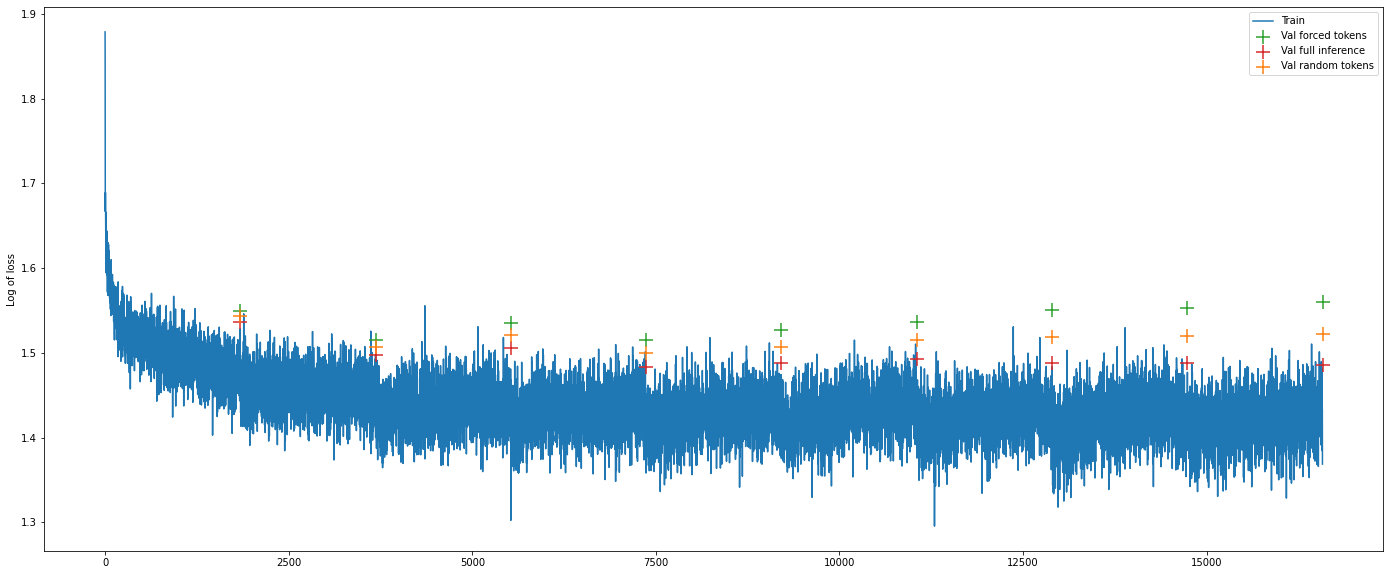

KeyboardInterrupt: ignored

In [97]:
plt.rcParams['figure.figsize']=24,10
encoder = EncoderRNN(256, len(eng2idx)).to(device)
decoder = DecoderRNN(256, len(rus2idx)).to(device)
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-2)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, collate_fn=collate_fn)
valloader = DataLoader(valset, batch_size=128, shuffle=False, collate_fn=collate_fn)
model = (encoder, decoder)


train_model(model, opt, trainloader, valloader, epochs=30)

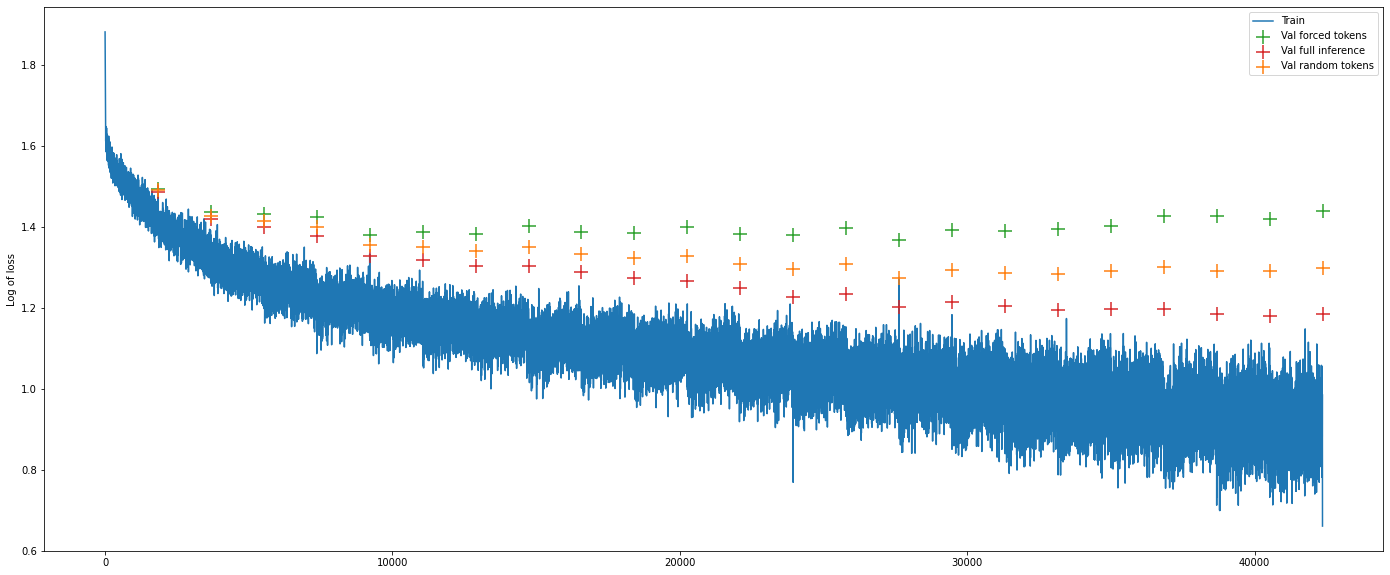

KeyboardInterrupt: ignored

In [98]:
plt.rcParams['figure.figsize']=24,10
encoder = EncoderRNN(256, len(eng2idx)).to(device)
decoder = DecoderRNN(256, len(rus2idx)).to(device)
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, collate_fn=collate_fn)
valloader = DataLoader(valset, batch_size=128, shuffle=False, collate_fn=collate_fn)
model = (encoder, decoder)


train_model(model, opt, trainloader, valloader, epochs=30)

**(0.2 балла)** Напишите функцию перевода с семплирование из распределения с температурой.


In [101]:
encoder.eval()
decoder.eval()
encoder = encoder.to("cpu")
decoder = decoder.to("cpu")

def evaluate(sentence, T=1.0):
    encoded = sentence2idx(sentence, eng2idx)
    output = []
    print(encoded)
    bs = 10
    with torch.no_grad():
        z = torch.LongTensor(encoded).view(1, -1).repeat(bs, 1)
        encoder_outputs, hidden = encoder(z, encoder.init_hidden(bs))
        inputs = z[:,0].view(-1,1)
        for i in range(20):
            outputs, hidden = decoder(inputs, hidden)
            sm=(outputs/T).softmax(dim=2)
            multinom_outputs = torch.multinomial(sm.squeeze(1), 1)
            output.append(multinom_outputs)
            inputs=multinom_outputs
            
    # print(output)
    # import pdb; pdb.set_trace()
    output=[x.numpy() for x in output]
    output = np.array(output).T
    # return output
    for s in output.reshape((10,20)):
        out = idx2sentence(s, idx2rus)
        print(out.replace('PAD', ""))

    
evaluate("What is going on?")

[1, 23, 14, 63, 46, 9, 2]
какая происходит  ? EOS EOS ? EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS ?
что происходит, происходит  ? EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS
за чем происходит  ? EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS ? EOS EOS
что идет происходит  ? EOS EOS EOS ? EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS
что происходит, идет  ? EOS EOS ? EOS ? EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS
что идет происходит  ? EOS EOS EOS ? EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS
это происходит  ? EOS EOS EOS EOS EOS EOS EOS EOS EOS ? EOS EOS EOS EOS  ?
что чего происходит  ? EOS EOS EOS ? EOS EOS EOS EOS EOS EOS  ? EOS EOS EOS
что идет будет  ? EOS EOS EOS EOS ? EOS EOS EOS EOS EOS EOS EOS EOS EOS ?
на ужин будет ? ? EOS EOS ? EOS EOS EOS EOS ? EOS EOS ? EOS EOS EOS EOS


In [108]:
evaluate("how are you, my dearest friend?", 2)

[1, 50, 34, 451, 33, 3, 278, 9, 2]
на поговорите тебя кто моя дядя пялиться  ? мне этого похоже нет домом ? EOS спасения  ? любимая
нравлюсь есть эта этои сплю повредил посмотрел продать  ? ? EOS EOS поехать EOS ? путешествовать EOS своем показалось,
вы тебе когда костюм подругу потерял повидать вас ? EOS значит ушел получал   ? справа ! ? !
журналы нужна моя папа  помогаете идет за год газ японии улыбался  явился EOS идет другим услышать ? EOS
как раз выглядит друга на твоеи EOS при EOS ? пальцев пуста руки своим навсегда спать хорошо ? вас заблудился
потребуется сеичас друг до своего женщина, UNK впечатление ? ? споешь мост ? . EOS тобои школе  EOS EOS
в мои папу вероятно, профессор UNK  . EOS посмотреть мне дал  EOS EOS простили ? EOS очков отъездом
лжец ходит мои мои знакомы ваше приходится нравлюсь  ? приходит  ? EOS настоящии всю его   почувствовал
тебе моя бумажнике лифт игрок ты ? на предположение считаешь кажутся момент почему пальцев  купим  . EOS EOS
ходит вам я ходил на мою